# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [89]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [90]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [91]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [92]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [93]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [94]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [95]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [96]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [97]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [98]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [99]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [100]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [101]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [102]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [103]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [104]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [105]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [106]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [107]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [108]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [109]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [110]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:05<00:00, 1344.30it/s]


In [111]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

# Dividing data in to train and validate and test 

In [112]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
x_train,x_test,y_train,y_test = train_test_split(preprocessed_reviews,final['Score'],test_size = 0.2, shuffle = False)

# [4] Featurization

## [4.1] BAG OF WORDS

In [190]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(x_train)
train_bow = count_vect.transform(x_train)
test_bow = count_vect.transform(x_test)
train_bow=preprocessing.normalize(train_bow)
test_bow=preprocessing.normalize(test_bow)
name=count_vect.get_feature_names()

## [4.2] Bi-Grams and n-Grams.

In [114]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [115]:
#tf-idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(x_train)
train_tfidf = tf_idf_vect.transform(x_train)
test_tfidf = tf_idf_vect.transform(x_test)

#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)


## [4.4] Word2Vec

In [116]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
for sentance in x_train:
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for sentance in x_test:
    list_of_sentance_test.append(sentance.split())

In [117]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8283536434173584), ('fantastic', 0.822059154510498), ('good', 0.8176743984222412), ('excellent', 0.8146673440933228), ('terrific', 0.8039119243621826), ('perfect', 0.7499452829360962), ('wonderful', 0.7401137351989746), ('amazing', 0.727171778678894), ('nice', 0.6974030137062073), ('fabulous', 0.6695287227630615)]
[('greatest', 0.7465769648551941), ('best', 0.7224655151367188), ('tastiest', 0.702219545841217), ('closest', 0.6248434782028198), ('ive', 0.6193991303443909), ('experienced', 0.6177552342414856), ('hardly', 0.6139978170394897), ('nastiest', 0.6094930171966553), ('richest', 0.5972404479980469), ('awful', 0.5872954726219177)]


In [118]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15616
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [119]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [04:52<00:00, 240.06it/s]


70218
50


In [120]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [01:21<00:00, 214.26it/s]


17555
50


#### [4.4.1.2] TFIDF weighted W2v

In [121]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [122]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 70218/70218 [1:14:54<00:00, 15.62it/s]


In [123]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [18:30<00:00, 15.81it/s]


# Applying Logistic Regression

In [124]:
## definition for confusion matrix
##https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [173]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='f1')
model.fit(train_bow,y_train)

print(model.best_estimator_)
print(model.score(test_bow, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9496606907728148


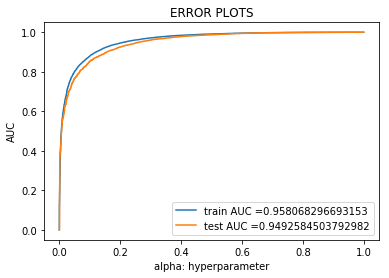

Train confusion matrix
[[ 7396  3766]
 [ 1341 57715]]
Test confusion matrix
[[ 2000  1019]
 [  472 14064]]


In [174]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=1,penalty='l1')
log.fit(train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(test_bow)))

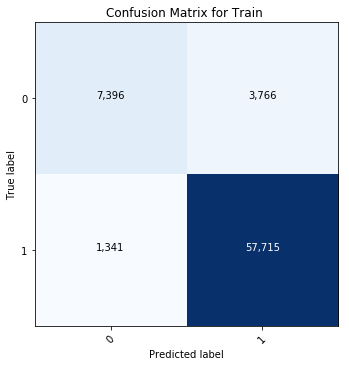

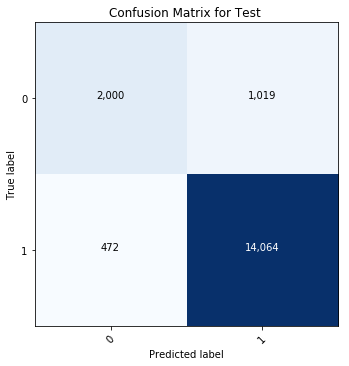

In [175]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 7396 , 3766],
                                              [  1341 , 57715]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 2000,1019],
                                              [  472,14064]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [176]:
# Please write all the code with proper documentation
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 

import numpy as np

clf = LogisticRegression(C=0.1, penalty='l1');
clf.fit(train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))
print('-'*40)
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))
print('-'*40)
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))
print('-'*40)
clf = LogisticRegression(C=10, penalty='l1');
clf.fit(train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))

203
----------------------------------------
10
----------------------------------------
0
----------------------------------------
6600


## observation
1) As we see that sparsity increases as c decreases and at last we kept c=10 for that sparsity is very much 
less when compared to c=0.01

2)By this we can say that as lambda increases sparsity increases and model goes underfit

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [177]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='f1')
model.fit(train_bow,y_train)

print(model.best_estimator_)
print(model.score(test_bow, y_test))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9513704686118479


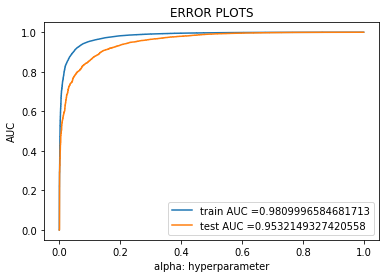

Train confusion matrix
[[ 8679  2483]
 [  903 58153]]
Test confusion matrix
[[ 2137   882]
 [  548 13988]]


In [178]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=10,penalty='l2')
log.fit(train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(test_bow)))

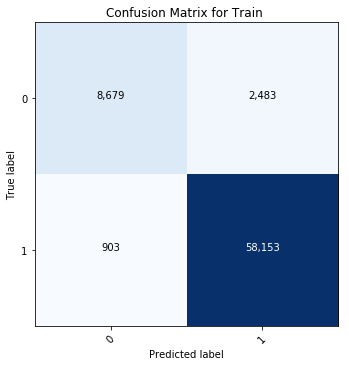

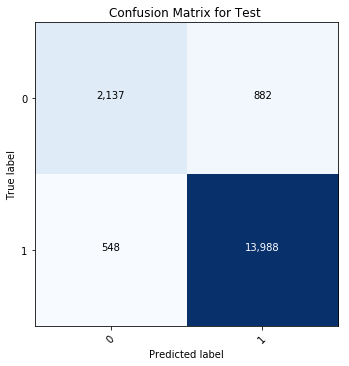

In [179]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 8679 , 2483],
                                              [  903 , 58153]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 2137,882],
                                              [  548,13988]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [192]:
# Please write all the code with proper documentation
import copy
weights=model.best_estimator_.coef_
trainpertub_bow=copy.deepcopy(train_bow) 
e=np.random.normal(0,0.01)
print(e)
trainpertub_bow.data += e
modelper = LogisticRegression(penalty='l2',C= 10)
modelper.fit(trainpertub_bow, y_train)

0.00806361077889168


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

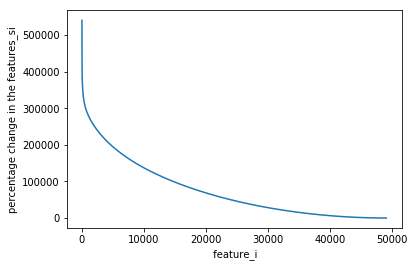

In [193]:
weightspert=modelper.coef_
weights_diff=abs((weightspert-weights)/weights)*100
d = np.sort(weights_diff).cumsum()
d=d[::-1]
plt.ylabel('percentage change in the features_si')
plt.xlabel(' feature_i')
plt.plot(d)

In [194]:
# Printing the features whose % change is more than a threshold t

print("To No of features weight has changed greater than 50% are: ", weights_diff[np.where(weights_diff > 50)].size)
feature=[]
print("\n collinearfeatures are:")
for i in np.where(weights_diff > 50)[1]:
    feature.append(name[i])
print(feature[:10])

To No of features weight has changed greater than 50% are:  686

 collinearfeatures are:
['abrupt', 'abundance', 'accepted', 'accomplished', 'adding', 'addressed', 'adjusted', 'adolescent', 'adversely', 'advertises']


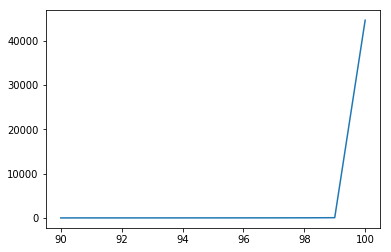

In [195]:
perc_change=[]
values=range(90,101)
for i in values:
    perc_change.append(np.percentile(weights_diff, i))
plt.plot(values,perc_change)

In [196]:
# By obserbing above plot we can see that threshold can be choosen as 99 because above that the change is very high it means
#multicollinearity could exist btw them.
# printing some  features which are  multicollinear 

weights_diff[weights_diff > np.percentile(weights_diff,99)]
feat=[]
for i in np.where(weights_diff > np.percentile(weights_diff,99))[1]:
    feat.append(name[i])
print(feat[:10])
print("No of features: ",len(feat))

['abundance', 'accepted', 'accomplished', 'adding', 'adjusted', 'adolescent', 'adversely', 'agave', 'alpha', 'ambitious']
No of features:  492


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [144]:
# Please write all the code with proper documentation
n=10
positive=[]
negative=[]
coefs = sorted(zip(model.best_estimator_.coef_[0], feat))
top = zip(coefs[:n], coefs[:-(n + 1):-1])
for (coef1, feat1), (coef2, feat2) in top:
        negative.append((coef1,feat1))
        positive.append((coef2,feat2))
print("\n____Top 10 Positive features\n")
i=0
for f in positive:
    print(i,f[0],"    ",f[1])
    i=i+1


____Top 10 Positive features

0 1.129677497447157      artificial
1 1.0661720612335717      many brands
2 0.9897142101475511      not stop
3 0.7102368329566324      not come
4 0.650829135749737      grow
5 0.3647613457491861      loose tea
6 0.3376837869448871      not care
7 0.2929296799297921      little bit
8 0.2907094020921928      max
9 0.14406165629917445      mention


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [145]:
# Please write all the code with proper documentation
print("____Top 10 negative features\n")
i=1
for f in negative:
    print(i,f[0],"    ",f[1])
    i=i+1

____Top 10 negative features

1 -1.621729358190805      mate
2 -1.3368700656702825      pretty
3 -0.8984534917329035      pear
4 -0.8774732262208049      anymore
5 -0.6649148221012138      percent
6 -0.5086451759510764      salt not
7 -0.4327322964469843      coffee strong
8 -0.42756667667935044      like chocolate
9 -0.3502915250011459      great tea
10 -0.19649952704624213      provides


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [146]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='f1')
model.fit(train_tfidf,y_train)

print(model.best_estimator_)
print(model.score(test_tfidf, y_test))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9569946961251309


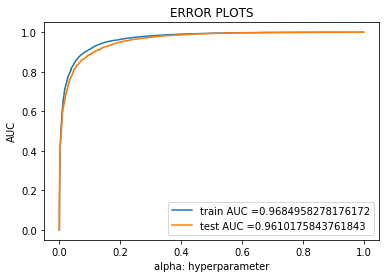

Train confusion matrix
[[ 7785  3377]
 [ 1070 57986]]
Test confusion matrix
[[ 2118   901]
 [  372 14164]]


In [147]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=1,penalty='l1')
log.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(test_tfidf)))

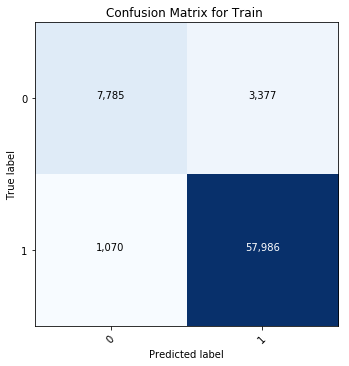

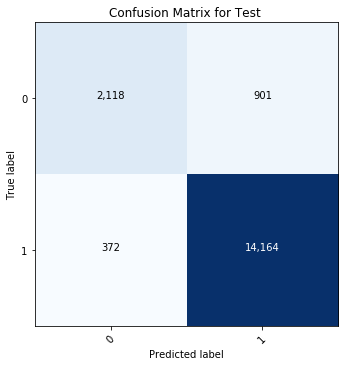

In [164]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 7785 , 3377],
                                              [  1070 , 57986]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 2118,901],
                                              [  372,14164]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [148]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='f1')
model.fit(train_tfidf,y_train)

print(model.best_estimator_)
print(model.score(test_tfidf, y_test))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9587923296613627


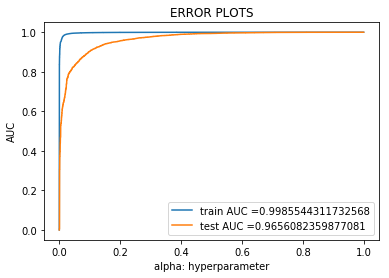

Train confusion matrix
[[10367   795]
 [  195 58861]]
Test confusion matrix
[[ 2243   776]
 [  436 14100]]


In [149]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=10,penalty='l2')
log.fit(train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(test_tfidf)))

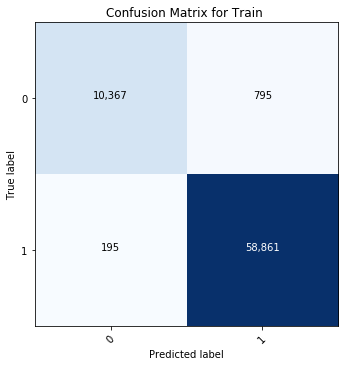

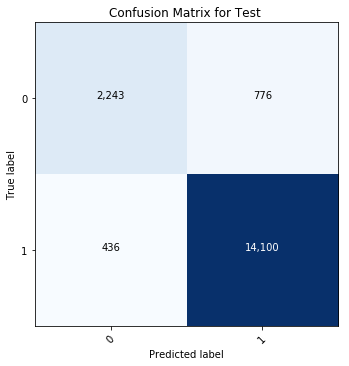

In [165]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 10367 , 795],
                                              [  195 , 58861]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 2243,776],
                                              [  436,14100]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [150]:
# Please write all the code with proper documentation
n=10
positive=[]
negative=[]
coefs = sorted(zip(model.best_estimator_.coef_[0], feat))
top = zip(coefs[:n], coefs[:-(n + 1):-1])
for (coef1, feat1), (coef2, feat2) in top:
        negative.append((coef1,feat1))
        positive.append((coef2,feat2))
print("\n____Top 10 Positive features\n")
i=0
for f in positive:
    print(i,f[0],"    ",f[1])
    i=i+1


____Top 10 Positive features

0 3.5050416750145237      son loves
1 3.031939444266206      coffee strong
2 2.233737235180929      tiny bit
3 2.0767624014919543      green mountain
4 1.707014461917931      red bull
5 1.6177806835891213      per oz
6 1.502829870858211      peppery
7 1.2930103292502686      little bit
8 1.2510483208111927      eat much
9 1.1804865548474692      not stop


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [151]:
# Please write all the code with proper documentation
print("____Top 10 negative features\n")
i=1
for f in negative:
    print(i,f[0],"    ",f[1])
    i=i+1

____Top 10 negative features

1 -3.0721712672269494      something else
2 -3.0461361254446193      good product
3 -2.791307357420785      like chocolate
4 -2.570269687981348      tossed
5 -1.3527162848657852      cancel
6 -1.0384380552031354      buying amazon
7 -0.7975434571211687      anymore
8 -0.7829860624617171      missed
9 -0.7299351784645044      not bad
10 -0.637582965021069      regularly


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [153]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='f1')
model.fit(sent_vectors_train,y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, y_test))

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9305282780200393


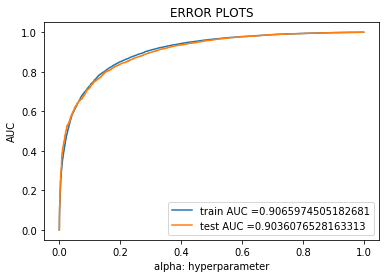

Train confusion matrix
[[ 5445  5717]
 [ 1992 57064]]
Test confusion matrix
[[ 1491  1528]
 [  559 13977]]


In [154]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=10,penalty='l1')
log.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(sent_vectors_test)))

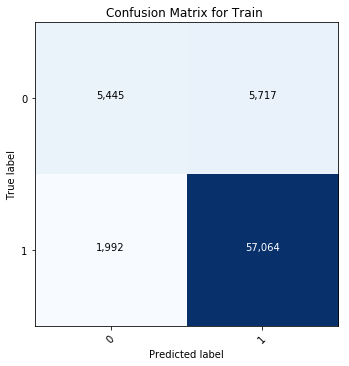

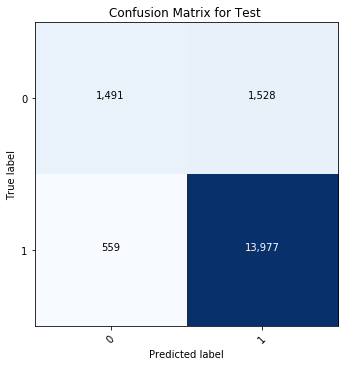

In [166]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 5445 , 5717],
                                              [  1992 , 57064]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 1491,1528],
                                              [  559,13977]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [155]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='f1')
model.fit(sent_vectors_train,y_train)

print(model.best_estimator_)
print(model.score(sent_vectors_test, y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9305264558182846


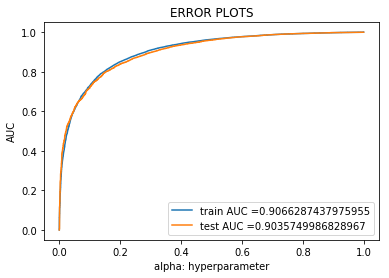

Train confusion matrix
[[ 5396  5766]
 [ 1963 57093]]
Test confusion matrix
[[ 1476  1543]
 [  546 13990]]


In [156]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=0.1,penalty='l2')
log.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(sent_vectors_test)))

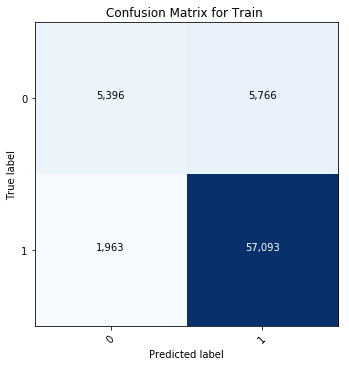

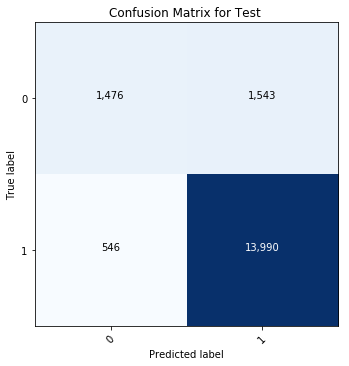

In [167]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 5396 , 5766],
                                              [  1963 , 57093]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 1476,1543],
                                              [  546,13990]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [157]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters,scoring='f1')
model.fit(tfidf_sent_vectors_train,y_train)

print(model.best_estimator_)
print(model.score(tfidf_sent_vectors_test, y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9237461279905095


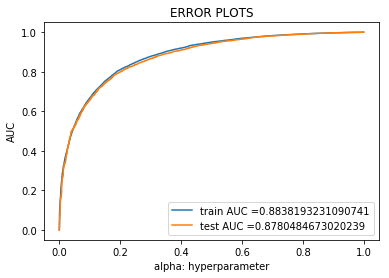

Train confusion matrix
[[ 4498  6664]
 [ 1826 57230]]
Test confusion matrix
[[ 1225  1794]
 [  518 14018]]


In [158]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=0.1,penalty='l1')
log.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(tfidf_sent_vectors_test)))

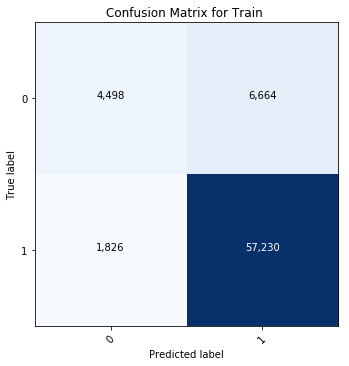

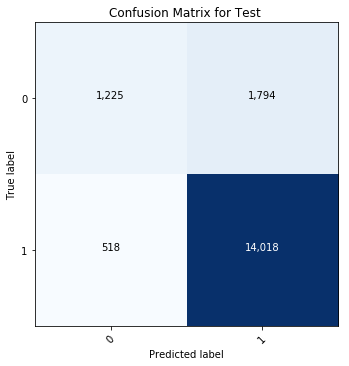

In [168]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 4498 , 6664],
                                              [  1826 , 57230]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 1225,1794],
                                              [  518,14018]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [160]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4,10**-3, 10**-2,10**-1, 10**0,10**1, 10**2,10**3, 10**4]}]

model = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters,scoring='f1')
model.fit(tfidf_sent_vectors_train,y_train)

print(model.best_estimator_)
print(model.score(tfidf_sent_vectors_test, y_test))

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9238120345350292


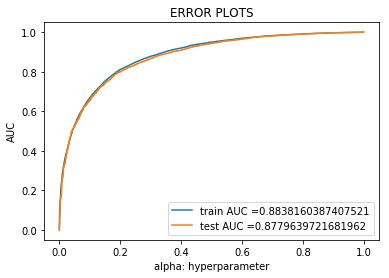

Train confusion matrix
[[ 4509  6653]
 [ 1842 57214]]
Test confusion matrix
[[ 1226  1793]
 [  519 14017]]


In [161]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


log = LogisticRegression(C=0.1,penalty='l2')
log.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, log.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, log.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, log.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, log.predict(tfidf_sent_vectors_test)))

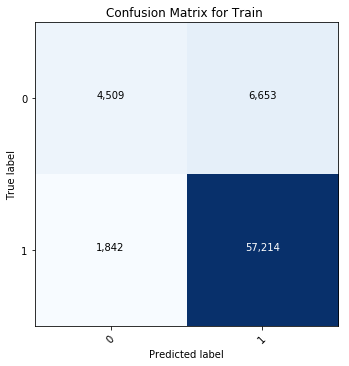

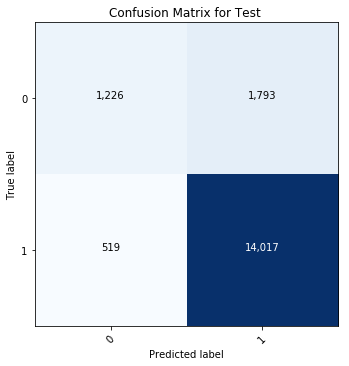

In [169]:
## printing  confusion matrices
plot_confusion_matrix(cm           = np.array([[ 4509 , 6653],
                                              [  1842 , 57214]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Train ")

plot_confusion_matrix(cm           = np.array([[ 1226,1793],
                                              [  519,14017]
                                              ]), 
                      normalize    = False,
                      target_names = [0, 1],
                      title        = "Confusion Matrix for Test ")


# [6] Conclusions

In [170]:
# reference from "http://zetcode.com/python/prettytable/"
from prettytable import PrettyTable
t = PrettyTable()
t.field_names = ["Vectorizer", "Model", "Hyper parameter", "TRAIN_AUC" , "TEST_AUC"]
t.add_row(["BOW", "l1",1,0.96,0.95 ])
t.add_row(["BOW", "l2", 10,0.98,0.95])
t.add_row(["TFIDF", "l1", 1,0.97,0.96])
t.add_row(["TFIDF", "l2", 10,0.99,0.97])
t.add_row(["W2V", "l1", 10,0.91,0.90])
t.add_row(["W2V", "l2", 0.1,0.91,0.90])
t.add_row(["TFIDFW2V", "l1", 0.1,0.88,0.88])
t.add_row(["TFIDFW2V", "l2", 0.1,0.88,0.88])
print(t)

+------------+-------+-----------------+-----------+----------+
| Vectorizer | Model | Hyper parameter | TRAIN_AUC | TEST_AUC |
+------------+-------+-----------------+-----------+----------+
|    BOW     |   l1  |        1        |    0.96   |   0.95   |
|    BOW     |   l2  |        10       |    0.98   |   0.95   |
|   TFIDF    |   l1  |        1        |    0.97   |   0.96   |
|   TFIDF    |   l2  |        10       |    0.99   |   0.97   |
|    W2V     |   l1  |        10       |    0.91   |   0.9    |
|    W2V     |   l2  |       0.1       |    0.91   |   0.9    |
|  TFIDFW2V  |   l1  |       0.1       |    0.88   |   0.88   |
|  TFIDFW2V  |   l2  |       0.1       |    0.88   |   0.88   |
+------------+-------+-----------------+-----------+----------+
